In [1]:
import os
import random
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import transforms
import numpy as np
from utils.datasets import letterbox
from utils.general import non_max_suppression, xywh2xyxy
from utils.plots import output_to_target, plot_skeleton_kpts, plot_one_box

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('/home/shackleford/Downloads/yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [26]:
img_file = '/mnt/purx/fyp/coco_kpts/images/train2017/' + random.choice(os.listdir('/mnt/purx/fyp/coco_kpts/images/train2017'))

In [28]:
image = cv2.imread(img_file)
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)   
output, _ = model(image)

In [29]:
output = non_max_suppression(output, 0.25, 0.65, nc=1, nkpt=model.yaml['nkpt'], kpt_label=True)
with torch.no_grad():
    output = output_to_target(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
output[:, 2:6] = xywh2xyxy(output[:, 2:6])

In [30]:
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    label = "cls%s-%.4f" % (int(output[idx, 1]), float(output[idx, 6]))
    xyxy = output[idx, 2:6]
    plot_one_box(xyxy, nimg, label=label, color=None, line_thickness=3)

In [31]:
op = dict(bbox=4, cls=1, kpts=17*3)
sum(op.values())

56

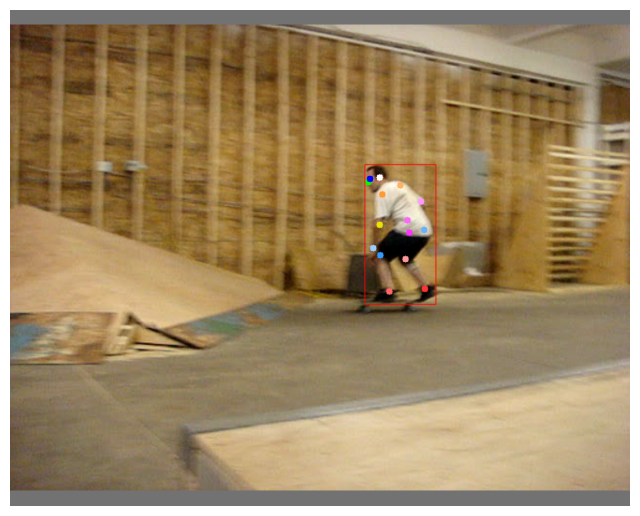

In [32]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()